In [3]:
import numpy as np
import pandas as pd
import pymc as pm

import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf

import bs4 as bs
import requests
import yfinance as yf
import datetime

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import beta
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF

from copulas.visualization import scatter_2d
from copulas.visualization import dist_1d
from copulas.multivariate import GaussianMultivariate

import tools as tl

# Read the CSV files
data1_cd4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
data1_cd4 = tl.RPM(data1_cd4)
df_0 = data1_cd4[["MT-CO1", "MT-CO2"]]

normalized_gibbs = pd.read_csv("mt-datasets/gibbs_results.csv")
observed = df_0.values
observed_Y = np.array(df_0[["MT-CO2"]])
name_1 = data1_cd4.columns.values[1]

protein_coding_genes = ["MT-CO1", "MT-CO2", "MT-CO3", "MT-CYB", 
                        "MT-ND1", "MT-ND2", "MT-ND3", "MT-ND4", 
                        "MT-ND4L", "MT-ND5", "MT-ND6", "MT-ATP6", 
                        "MT-ATP8"]
normalized_gibbs.columns=protein_coding_genes
df_gib = normalized_gibbs[["MT-CO1", "MT-CO2"]]
df_gib = tl.filter_outliers(df_gib)
name_1 = protein_coding_genes[0]
name_2 = protein_coding_genes[1]

In [4]:
df = tl.filter_outliers(df_0)
df_gib = tl.filter_outliers(df_gib)
scatter_2d(df)

In [5]:

dist_1d(data1_cd4['MT-CO3'], title=name_1)


In [6]:
dist_1d(df_gib[name_1], title=name_1)

In [8]:
copula = GaussianMultivariate()
copula.fit(df)
print(df[name_1])

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



0        77441.0
1       126984.0
2        67511.0
3        89606.0
4        23346.0
          ...   
2872    163934.0
2873     92199.0
2874     59524.0
2875     99723.0
2876     45918.0
Name: MT-CO1, Length: 2877, dtype: float64


In [9]:
cdf_1= copula.univariates[0].cdf(df[name_1])
dist_1d(cdf_1, title=name_1)

In [10]:
from copulas.visualization import compare_2d
import seaborn as sns
copula.fit(df)
synthetic = copula.sample(len(df))

copula.fit(df_gib)
synthetic_1 = copula.sample(len(df_gib))

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt



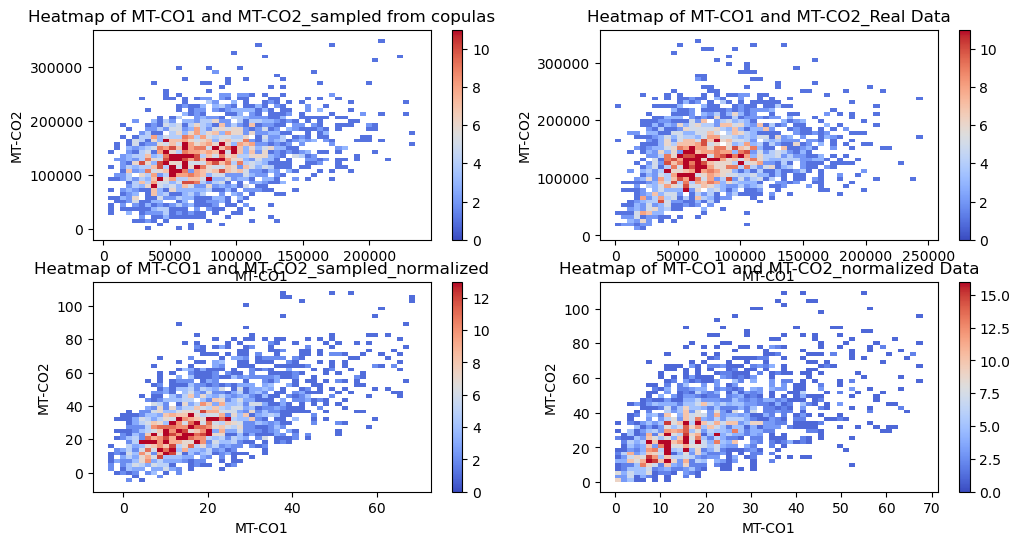

In [11]:

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
heatmap = sns.histplot(data=synthetic, x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_sampled from copulas')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)

plt.subplot(2, 2, 2)
heatmap = sns.histplot(data=tl.filter_outliers(data1_cd4[[name_1,name_2]]), x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_Real Data')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)


plt.subplot(2, 2, 3)
heatmap = sns.histplot(data=synthetic_1, x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_sampled_normalized')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)

plt.subplot(2, 2, 4)
heatmap = sns.histplot(data=tl.filter_outliers(normalized_gibbs[[name_1,name_2]]), x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_normalized Data')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)

plt.show()

In [12]:
compare_2d(df, synthetic)

In [16]:
compare_2d(df, synthetic_1)

In [13]:
synthetic.corr().iloc[0, 1]

0.35703057591821385

In [14]:
cor = tl.get_cor_copulas(data1_cd4[protein_coding_genes], protein_coding_genes)

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarni

In [14]:
cor_norm=tl.get_cor_copulas(normalized_gibbs, protein_coding_genes)

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWa

array([[0.        , 0.56611572, 0.5664251 , 0.53652113, 0.43692172,
        0.34761639, 0.43795303, 0.30842495, 0.48185131, 0.47259466,
        0.28257141, 0.31903889, 0.51752131],
       [0.        , 0.        , 0.66650949, 0.62787502, 0.5111962 ,
        0.39720378, 0.42143176, 0.31473988, 0.573197  , 0.4082254 ,
        0.17865883, 0.2709643 , 0.62020509],
       [0.        , 0.        , 0.        , 0.607741  , 0.53222022,
        0.43021093, 0.44320726, 0.37185469, 0.57532   , 0.46258673,
        0.22537326, 0.3423572 , 0.64830711],
       [0.        , 0.        , 0.        , 0.        , 0.54388304,
        0.44249753, 0.44564405, 0.41735482, 0.58386736, 0.50033693,
        0.27426603, 0.36563461, 0.64400557],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.49823043, 0.51959704, 0.41120327, 0.54313619, 0.52510133,
        0.32977999, 0.40881877, 0.58680511],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.47414

In [77]:
cor_o = np.zeros((13,13))
for i in range(13):
    for j in range(i+1,13):
        df_0 = normalized_gibbs[[protein_coding_genes[i], protein_coding_genes[j]]]
        df = tl.filter_outliers(df_0)
        copula.fit(df)
        synthetic = copula.sample(len(df))
        cor_o[i,j]=synthetic.corr().iloc[0, 1]
        print(cor_o[i,j])
print(cor_o)



/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWa

[[0.         0.55784521 0.57909839 0.5436443  0.44367122 0.37533352
  0.44221224 0.33550643 0.4852779  0.4377222  0.25044558 0.30806638
  0.51602893]
 [0.         0.         0.64787413 0.65870057 0.50152234 0.43325383
  0.41144724 0.33519477 0.53318685 0.44802223 0.17621425 0.27009395
  0.62672169]
 [0.         0.         0.         0.63085336 0.5265455  0.44027156
  0.46400561 0.38811397 0.58092036 0.4884362  0.2178663  0.3180743
  0.65378551]
 [0.         0.         0.         0.         0.54536356 0.44457138
  0.48087183 0.35914873 0.59784203 0.48612146 0.27482723 0.35021408
  0.6386107 ]
 [0.         0.         0.         0.         0.         0.47790308
  0.49797367 0.43195477 0.57129018 0.48082382 0.30713886 0.40584733
  0.58956125]
 [0.         0.         0.         0.         0.         0.
  0.48700661 0.4209125  0.48219199 0.49065007 0.30760341 0.37910733
  0.48401905]
 [0.         0.         0.         0.         0.         0.
  0.         0.44630839 0.46135289 0.47272164 0.3

In [13]:
# importing packages 
import scipy.stats as stats 

# no of hours a student studies 
# in a week vs expected no of hours 
observed_data = synthetic
expected_data = df


# Chi-Square Goodness of Fit Test 
chi_square_test_statistic, p_value = stats.chisquare( 
	observed_data, expected_data) 

# chi square test statistic and p value 
print('chi_square_test_statistic is : ' +
	str(chi_square_test_statistic)) 
print('p_value : ' + str(p_value)) 


# find Chi-Square critical value 
print(stats.chi2.ppf(1-0.05, df=6)) 


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
[0.01113224 0.01989384]

In [1]:
# Import the required libraries
import numpy as np
import pyvinecopulib as pv
from scipy.stats import poisson

# Simulate dummy data
np.random.seed(1234)  # seed for the random generator
x = np.random.normal(size=(30, 1)) * np.ones((30, 5)) + 0.5 * np.random.normal(
  size=(30, 5)
)

# Convert to pseudo-observations
u = pv.to_pseudo_obs(x)

# Some fit controls
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.gaussian])


# A continuous example
fit_cont = pv.Vinecop(u, controls=controls)
str(fit_cont)

# Model for discrete data
# Transform to Poisson margins
x_poisson = poisson.ppf(u, 1)

# using Poisson(1) transformation
u_disc = np.hstack((poisson.cdf(x_poisson, 1), poisson.cdf(x_poisson - 1, 1)))

# Fit vine copula model for discrete data
fit_disc = pv.Vinecop(u_disc, var_types=["d"] * 5, controls=controls)
str(fit_disc)

# Model for mixed data
# Transform first variable to Poisson margin
x_poisson_mixed = poisson.ppf(u[:, 0], 1)
u_disc_mixed = np.hstack(
  (
    poisson.cdf(x_poisson_mixed, 1).reshape(-1, 1),
    u[:, 1:5],
    poisson.cdf(x_poisson_mixed - 1, 1).reshape(-1, 1),
  )
)

# Fit vine copula model for mixed data
fit_mixed = pv.Vinecop(
  u_disc_mixed, var_types=["d"] + ["c"] * 4, controls=controls
)
str(fit_mixed)

'<pyvinecopulib.Vinecop>\n** Tree: 0\n1,5 <-> Gaussian, parameters = 0.825327\n4,3 <-> Gaussian, parameters = 0.817544\n2,5 <-> Gaussian, parameters = 0.896285\n3,5 <-> Gaussian, parameters = 0.890737\n** Tree: 1\n1,3 | 5 <-> Gaussian, parameters = 0.316836\n4,5 | 3 <-> Gaussian, parameters = 0.238509\n2,3 | 5 <-> Gaussian, parameters = 0.0430262\n** Tree: 2\n1,4 | 3,5 <-> Gaussian, parameters = 0.334657\n4,2 | 5,3 <-> Gaussian, parameters = 0.31286\n** Tree: 3\n1,2 | 4,3,5 <-> Gaussian, parameters = 0.0545793\n'